# Challenge Exercise: What insights can homology provide on a weather dataset?

## Equipo

- Juan Pablo Echeagaray González, A00830646


## Dataset

Let's try to get insights from a real dataset our ENSO forecasting model on old data (i.e. early 1900s) from the Cobe SST dataset. There is significantly more uncertainty with this data than there is with newer data, since the advent of remote sensing and data sources has improved.

GOAL OF THIS EXERCISE: you have learned several data visualization/exploration tools. Use the functions on kmeans clustering, simplicial complexes, persistent homology, persistent diagrams, persistent barcodes, turning a time-series signal into a point cloud to try to derive an exploratory analysis of the provided dataset. Your goal is to understand and be able to explain clearly patterns that you observe in the dataset. Some things to try:
-  How would you slice the dataset? In what resolution are you looking for those patterns?
-  What is the connection between the target variable and the predictor variables? Can you derive some of these insights from the data?
- Is there a periodic footprint in the data? Could this be useful?

Dataset summary:
-  Target variable: flow (m3 / sec) – one location
- Predictor Variables: Precipitation (mm) and Temperature (deg C) – 9 locations
- Dates available: 1/1/1957 – 12/26/2016

## Instalación de librerías

In [1]:
!pip install giotto-tda gudhi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 34.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 65.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 452.9/452.9 kB 29.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 73.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 526.4/526.4 kB 33.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 59.6 MB/s eta 0:00:00


## Dependencias

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pickle
import numpy as np
import pandas as pd
import gtda as gt
import gudhi as gd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go

# Dependencias específicas
from gtda.time_series import SingleTakensEmbedding, takens_embedding_optimal_parameters
from sklearn.decomposition import PCA
from gtda.plotting import plot_point_cloud
from sklearn.ensemble import IsolationForest


## Lectura de datos

In [10]:
def load_data():
    with open('/content/drive/Shareddrives/topology/TDA_ClimateAI-main/IntroNotebooks/uke_eggedal_data_challenge.pkl', 'rb') as f:
        data = pickle.load(f)

    print(f"Lat, Long: {data['obs_lon_lat']}")

    flow_frame = {'flow': data['flow'], 'dates': data['flow_dates']}
    flow_df = pd.DataFrame(flow_frame).reset_index().drop(columns='index')

    obs_dates = data['obs_dates'].reset_index().drop(columns='index')
    obs_dates = obs_dates.rename(columns={0: 'obs_dates'})

    tas_cols = [f'temp_{i}' for i in range(9)]
    tas_df = pd.DataFrame.from_records(data['obs_tas'], columns=tas_cols)

    pres_cols = [f'rain_{i}' for i in range(9)]
    pres_df = pd.DataFrame.from_records(data['obs_pr'], columns=pres_cols)

    obs_df = pd.concat([obs_dates, tas_df, pres_df], axis=1)

    return flow_df, obs_df

In [11]:
flow_df, obs_df = load_data()

Lat, Long: [9.37, 60.23]


In [6]:
obs_df

,obs_dates,temp_0,temp_1,temp_2,temp_3,temp_4,temp_5,temp_6,temp_7,temp_8,rain_0,rain_1,rain_2,rain_3,rain_4,rain_5,rain_6,rain_7,rain_8
0,1957-01-01,-10.600000,-9.7,-6.7,-8.800000,-8.900000,-7.500000,-8.1,-6.5,-5.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1,0.1
1,1957-01-02,-20.500000,-19.1,-12.0,-17.700001,-17.700001,-13.100000,-15.5,-11.8,-9.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.1
2,1957-01-03,-23.600000,-22.5,-15.1,-21.400000,-21.400000,-16.299999,-19.4,-14.6,-12.2,0.1,0.0,0.3,0.1,0.3,0.3,0.4,0.3,0.5
3,1957-01-04,-16.200001,-16.0,-14.1,-15.600000,-15.400000,-14.500000,-15.0,-13.8,-11.9,1.0,0.0,1.0,1.1,0.9,0.7,0.8,0.4,0.6
4,1957-01-05,-7.900000,-7.8,-9.5,-7.600000,-7.500000,-8.000000,-7.4,-8.6,-8.2,9.3,8.6,8.0,8.9,8.7,10.2,9.3,10.1,9.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21541,2015-12-27,-12.500000,-11.7,-8.6,-11.000000,-10.900000,-9.200000,-9.7,-8.4,-7.5,2.2,0.1,1.1,1.5,0.1,0.0,0.0,0.0,0.0
21542,2015-12-28,-12.500000,-11.9,-9.1,-11.400000,-11.200000,-9.800000,-10.6,-8.6,-7.5,5.5,4.9,8.3,6.1,3.7,5.0,5.4,0.0,5.1
21543,2015-12-29,-11.900000,-11.4,-8.4,-10.800000,-10.800000,-8.600000,-9.3,-7.2,-6.3,1.8,1.7,2.1,2.7,0.2,0.8,2.2,0.0,0.0
21544,2015-12-30,-7.000000,-6.5,-3.4,-5.900000,-6.100000,-4.800000,-5.0,-3.8,-3.0,4.1,3.5,4.6,5.1,3.5,3.4,3.2,0.0,3.6


In [ ]:
flow_df

,flow,dates
0,1.723781,1958-01-04
1,0.960882,1958-01-05
2,0.001000,1958-01-06
3,0.001000,1958-01-07
4,0.316796,1958-01-08
...,...,...
21537,4.843290,2016-12-22
21538,3.756970,2016-12-23
21539,3.556818,2016-12-24
21540,3.402133,2016-12-25


In [ ]:
df = obs_df.merge(flow_df, left_on='obs_dates', right_on='dates')
df.drop(columns='dates', axis=0,  inplace=True)
df.head()

,obs_dates,temp_0,temp_1,temp_2,temp_3,temp_4,temp_5,temp_6,temp_7,temp_8,rain_0,rain_1,rain_2,rain_3,rain_4,rain_5,rain_6,rain_7,rain_8,flow
0,1958-01-04,-12.8,-13.000000,-13.0,-12.5,-12.500000,-12.7,-12.000000,-12.5,-12.9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.723781
1,1958-01-05,-7.8,-7.900000,-8.4,-7.0,-7.300000,-8.6,-6.500000,-7.7,-8.3,2.0,2.2,3.0,3.3,3.7,0.7,3.1,4.2,1.1,0.960882
2,1958-01-06,-11.0,-9.900000,-6.5,-8.5,-9.000000,-7.4,-7.900000,-6.8,-5.8,12.7,11.0,16.5,12.5,11.2,12.2,14.1,14.2,10.5,0.001000
3,1958-01-07,-13.2,-12.200000,-7.9,-10.7,-11.300000,-9.8,-10.100000,-8.5,-7.4,6.6,6.9,9.6,7.3,6.5,5.2,10.4,5.7,3.7,0.001000
4,1958-01-08,-19.9,-19.299999,-15.4,-18.4,-18.700001,-16.9,-17.700001,-15.9,-14.9,3.4,3.6,2.7,3.5,3.8,3.3,2.9,4.0,3.5,0.316796


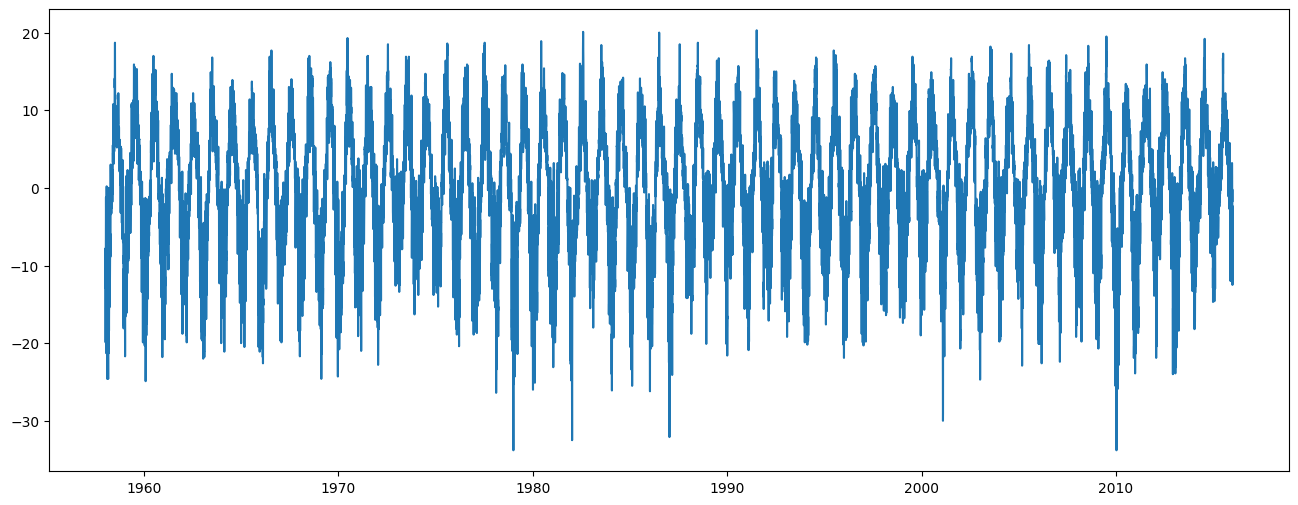

In [ ]:
plt.figure(figsize=(16, 6))
plt.plot(df['obs_dates'], df['temp_0'])
plt.show()

## Visualizació de nervios

In [ ]:
def nerve_plotter(data, simplicial_complex):
    # Create a 3D scatter plot of the data points
    fig = go.Figure(data=[go.Scatter3d(x=data[:,0], y=data[:,1], z=data[:,2], mode='markers', marker=dict(size=3))])

    # Add the simplices to the plot
    for simplex in simplicial_complex:
        if len(simplex[0]) == 2:
            fig.add_trace(go.Scatter3d(x=data[list(simplex[0]),0], y=data[list(simplex[0]),1], z=data[list(simplex[0]),2], mode='lines', line=dict(width=2)))
        elif len(simplex[0]) == 3:
            fig.add_trace(go.Mesh3d(x=data[list(simplex[0]),0], y=data[list(simplex[0]),1], z=data[list(simplex[0]),2], opacity=0.2, color='black'))

    # Set the axis labels and layout
    fig.update_layout(scene=dict(xaxis_title='X', yaxis_title='Y', zaxis_title='Z'))
    fig.show()

## Relación entre flow y demás variables

<Axes: >

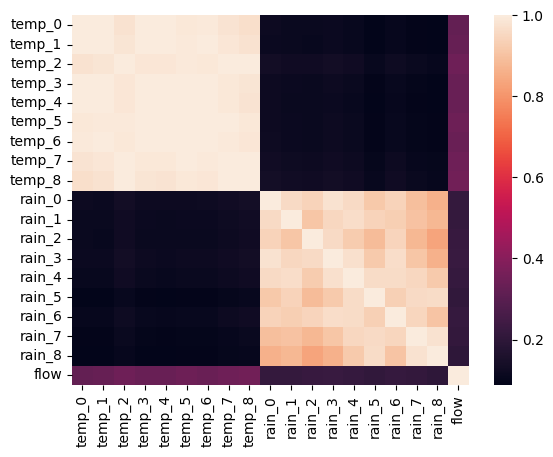

In [ ]:
sns.heatmap(df.corr(numeric_only=True))


## Análisis de periodicidad

In [ ]:
max_embedding_dimension = 140
max_time_delay = 140
stride = 10

embedder_periodic = SingleTakensEmbedding(
    parameters_type="search",
    n_jobs=-1,
    time_delay=max_time_delay,
    dimension=max_embedding_dimension,
    stride=stride,
)

def fit_embedder(embedder: SingleTakensEmbedding, y: np.ndarray, verbose: bool=True):
    """Fits a Takens embedder and displays optimal search parameters."""
    
    y_embedded = embedder.fit_transform(y)

    if verbose:
        print(f"Shape of embedded time series: {y_embedded.shape}")
        print(
            f"Optimal embedding dimension is {embedder.dimension_} and time delay is {embedder.time_delay_ / 12} years"
        )

    return y_embedded, embedder.time_delay_ / 12

delays = []
for i in range(9):
    y_embedded, years_delay = fit_embedder(embedder_periodic, obs_df[f'rain_{i}'])
    delays.append(years_delay)


Shape of embedded time series: (2114, 4)
Optimal embedding dimension is 4 and time delay is 11.333333333333334 years
Shape of embedded time series: (1995, 14)
Optimal embedding dimension is 14 and time delay is 10.25 years
Shape of embedded time series: (1978, 14)
Optimal embedding dimension is 14 and time delay is 11.333333333333334 years
Shape of embedded time series: (1979, 17)
Optimal embedding dimension is 17 and time delay is 9.166666666666666 years
Shape of embedded time series: (1969, 15)
Optimal embedding dimension is 15 and time delay is 11.083333333333334 years
Shape of embedded time series: (1978, 14)
Optimal embedding dimension is 14 and time delay is 11.333333333333334 years
Shape of embedded time series: (1978, 14)
Optimal embedding dimension is 14 and time delay is 11.333333333333334 years
Shape of embedded time series: (1995, 14)
Optimal embedding dimension is 14 and time delay is 10.25 years
Shape of embedded time series: (1989, 16)
Optimal embedding dimension is 16 a

In [ ]:
np.mean(delays)

10.592592592592593

In [ ]:
y_embedded, _ = fit_embedder(embedder_periodic, obs_df['temp_0'])
pca = PCA(n_components=3)
y_embedded_pca = pca.fit_transform(y_embedded)
plot_point_cloud(y_embedded_pca)


Shape of embedded time series: (2102, 7)
Optimal embedding dimension is 7 and time delay is 7.333333333333333 years


In [ ]:
data = obs_df['temp_0'].to_numpy().reshape(-1, 1)
model = IsolationForest(n_estimators=100, max_samples='auto', random_state=42)
model.fit(data)
y_pred = model.predict(data)
X_denoised = data[y_pred == 1]

y_embedded, _ = fit_embedder(embedder_periodic, X_denoised)
pca = PCA(n_components=3)
y_embedded_pca = pca.fit_transform(y_embedded)

plot_point_cloud(y_embedded_pca)

Shape of embedded time series: (1611, 7)
Optimal embedding dimension is 7 and time delay is 5.583333333333333 years


---Delaunay Complex---
Delaunay complex is of dimension  3  -  44723  simplices -  1611  vertices.


<Figure size 640x480 with 0 Axes>

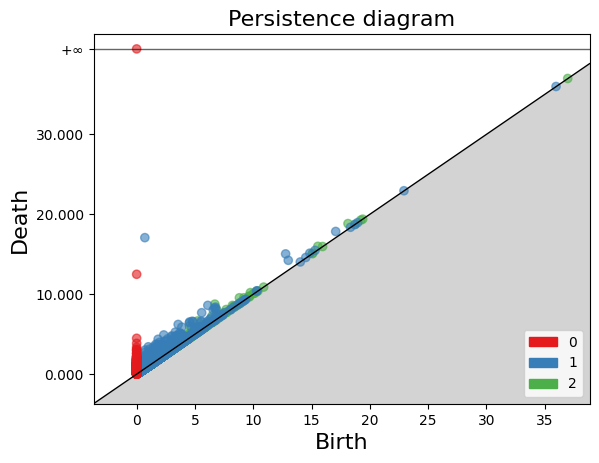

In [ ]:
print('---Delaunay Complex---')
dl = gd.AlphaComplex(points=y_embedded_pca)
stree_dl = dl.create_simplex_tree()
print('Delaunay complex is of dimension ', stree_dl.dimension(), ' - ',
stree_dl.num_simplices(), ' simplices - ', stree_dl.num_vertices(), ' vertices.')
simplices_dl = [i[0] for i in stree_dl.get_skeleton(3)]

# nerve_plotter(y_embedded_pca, stree_dl.get_skeleton(3))

plt.figure()
dgm_dl = stree_dl.persistence()
gd.plot_persistence_diagram(dgm_dl, legend=True)
plt.show()

- [verificar que ENSO afecta la lluvia] Una vez conociendo la periodicidad del niño, podríamos verificar que los efectos del niño pueden ser vistos también en las mediciones de temperatura
